## Libraries

In [ ]:
!pip install kaggle

In [ ]:
!pip install -U lightautoml

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# Warningの無効化
import warnings
warnings.filterwarnings('ignore')

# データフレームcolumの全表示
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

Here we setup the constants to use in the kernel:

- N_THREADS - number of vCPUs for LightAutoML model creation
- N_FOLDS - number of folds in LightAutoML inner CV
- RANDOM_STATE - random seed for better reproducibility
- TIMEOUT - limit in seconds for model to train
- TARGET_NAME - target column name in dataset

In [ ]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 72000
TARGET_NAME = 'pressure'

In [ ]:
# for reproducibility
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

## Load Data

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it. ##
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

In [ ]:
!kaggle competitions download -c ventilator-pressure-prediction

In [ ]:
DEBUG = False

In [ ]:
# train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
# test  = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
# submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [ ]:
train = pd.read_csv(r'../content/train.csv.zip')
test  = pd.read_csv(r'../content/test.csv.zip')
submission = pd.read_csv(r'../content/sample_submission.csv.zip')

In [ ]:
if DEBUG:
    train = train[:80*1000]

In [ ]:
train.shape, test.shape, submission.shape

In [ ]:
train

In [ ]:
train.describe()

In [ ]:
test['pressure'] = 0

In [ ]:
test

In [ ]:
test.describe()

## Add Feature

In [ ]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    return df

In [ ]:
train = add_features(train)
test = add_features(test)

In [ ]:
train

In [ ]:
train.shape

In [ ]:
train.info()

In [ ]:
test

In [ ]:
test.shape

## LightAutoML model building

#### Task setup
On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found here in our documentation):

add Codeadd Markdown

In [ ]:
task = Task('reg', loss='mae', metric='mae')

#### Feature roles setup
To solve the task, we need to setup columns roles. The only role you must setup is target role, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [ ]:
roles = {
    'drop': 'id',
    'group': 'breath_id', # for group k-fold
    'target': TARGET_NAME
}

In [ ]:
%%time
# Fitting
automl = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['lgb', 'lgb_tuned', 'linear_l2']]},
                       tuning_params={'max_tuning_time': 1800}
                      )
automl.fit_predict(train, roles=roles)

In [ ]:
# Prediction
test_pred = automl.predict(test)

In [ ]:
test_pred

In [ ]:
submission[TARGET_NAME] = test_pred.data[:, 0]

#### Feature importance
For feature importances calculation we have 2 different methods in LightAutoML:

- Fast (fast) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (accurate) - this method calculate features permutation importances for the whole LightAutoML model based on the new labelled data. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In [ ]:
fi_score = automl.get_feature_scores('fast').sort_values('Importance', ascending=True)

In [ ]:
plt.figure(figsize=(10, 30))
fi_score.set_index('Feature')['Importance'].plot.barh(fontsize=16)
plt.title('Feature importance', fontsize=18)
plt.show()

## Export

In [ ]:
submission

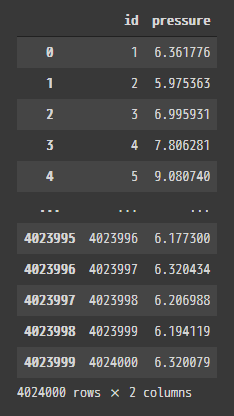

In [ ]:
submission.to_csv('submission.csv', index=False)
print('./submission.csv')

In [ ]:
!kaggle competitions submit -c ventilator-pressure-prediction -f submission.csv -m "Message"